# Model ABR responses to various US stimuli

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from usnm2p.utils import dB_to_amplitude, resample, find_nearest, apply_rolling_window, sigmoid
from usnm2p.logger import logger
from usnm2p.fileops import get_data_root
from usnm2p.wfutils import *
from usnm2p.abr_utils import compute_predicted_ABR, plot_ABR_vs_parameter

## Deatiled pipeline (Hyun-Choi et al. (2023) Figure 1)

### Load ABR thresholds and ABR impulse response data

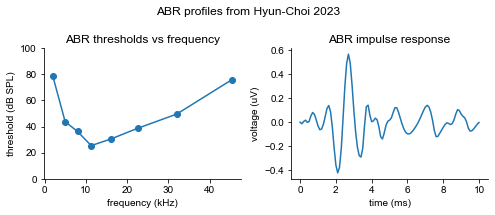

In [3]:
# Root folder for ABR data
ABR_dataroot = get_data_root(kind='ABR')

# Load ABR threshold data from Hyun-Choi 2023
ABR_thresholds = pd.read_csv(
    os.path.join(ABR_dataroot, 'HyunChoi2023_mouse_ABR_thresholds.csv')
).set_index('frequency (kHz)')['ABR threshold (dB SPL)']

# Load digitized trace of average ABR impulse response from Hyun-Choi 2023
impulse_ABR = pd.read_csv( 
    os.path.join(ABR_dataroot, 'HyunChoi2023_digitized_impulse_ABR.csv')
).set_index('time (ms)')['voltage (uV)']

# Create figure 
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.despine(fig=fig)
fig.suptitle('ABR profiles from Hyun-Choi 2023')
    
# Plot ABR thresholds vs frequency
ax = axes[0]
ax.set_title('ABR thresholds vs frequency')
ABR_thresholds.plot(ax=ax, marker='o')
ax.set_ylabel('threshold (dB SPL)')
ax.set_ylim(0, 100)

# Plot ABR impulse response
ax = axes[1]
ax.set_title('ABR impulse response')
ax.set_ylabel('voltage (uV)')
impulse_ABR.plot(ax=ax)

# Post-process figure
fig.tight_layout()

### Construct US waveform

 2025/06/03 10:52:16: assembling US waveform signal


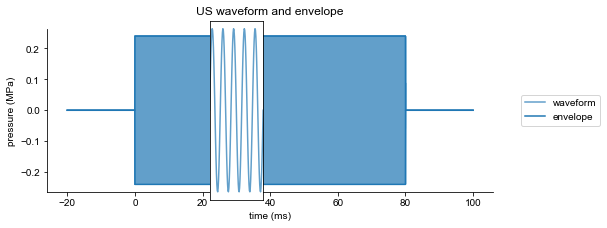

In [4]:
# Waveform parameters
Fdrive = 500e3 # carrier frequency (Hz)
tstim = 80e-3  # burst duration (s)
Pa_ref = 0.24  # pressure amplitude (MPa), i.e. 0.17 MPa RMS pressure
npc = 25  # number of points per cycle (using 25 to accurately represent the waveform, but in theory 4 is sufficient for spectrogram up to 2 * Fdrive)
ringup_time = 0. #3 / Fdrive  # ring-up time (s), i.e. 3 cycles at Fdrive

# Inset zoom-in plot parameters
inset_ncycles = 5  # number of carrier cycles to zoom in on
inset_tstart = 30e-3  # inset start time (s)

# Assemble US waveform signal
logger.info('assembling US waveform signal')
t, P_t, Penv_t = get_waveform(Fdrive, Pa_ref, tstim, npc=npc, tramp=ringup_time)

# Plot US waveform and envelope
zoom_tbounds = np.array([0, inset_ncycles / Fdrive]) + inset_tstart  # time bounds (s)
fig, *_ = plot_waveform(
    t, P_t, Penv_t, 
    ylabel='pressure (MPa)', title='US waveform and envelope', zoom_tbounds=zoom_tbounds)

### Compute US pressure waveform spectrogram, differentiate over time and scale by auditory sensitivity

 2025/06/03 10:52:17: computing P(t) spectrogram
 2025/06/03 10:52:17: deriving spectrogram over time
 2025/06/03 10:52:17: interpolating ABR thresholds over frequency range
 2025/06/03 10:52:17: scaling spectrogram derivative by frequency-dependent sensitivities


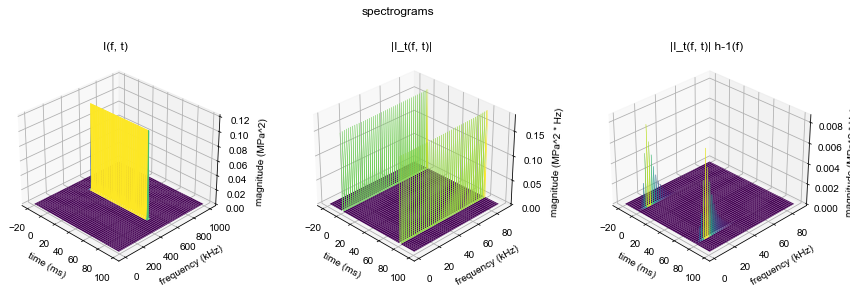

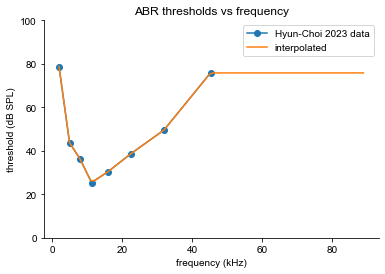

In [5]:
# Create spectrograms figure
fig = plt.figure(figsize=(15, 4))
fig.suptitle('spectrograms', y=1.05)

# Compute P(t) spectrogram
logger.info('computing P(t) spectrogram')
freqs, times, I_ft = get_spectrogram(t, P_t)

# Restrict to frequencies below 2 * Fdrive
fmask = freqs <= 2 * Fdrive
freqs = freqs[fmask]
I_ft = I_ft[fmask]

# Plot spectrogram output
ax = fig.add_subplot(1, 3, 1, projection='3d')
plot_spectrogram(times, freqs, I_ft, ax=ax, title='I(f, t)', zunit='MPa^2')

# Differentiate spectrogram over time
logger.info('deriving spectrogram over time')
dI_ft = np.abs(np.diff(I_ft) / np.diff(times))

# Restrict to frequencies within mouse hearing range (2 - 90 kHz) 
fmask = np.logical_and(freqs >= 2e3, freqs <= 90e3)
freqs = freqs[fmask]
dI_ft = dI_ft[fmask]

# Plot spectrogram derivative output
ax = fig.add_subplot(1, 3, 2, projection='3d')
plot_spectrogram(times[:-1], freqs, dI_ft, ax=ax, title='|I_t(f, t)|', zunit='MPa^2 * Hz')

# Interpolate ABR thresholds (from Hyun-Choi 2023) over frequency range
logger.info('interpolating ABR thresholds over frequency range')
h_dB = np.interp(freqs, ABR_thresholds.index * 1e3, ABR_thresholds.values)  # dB SPL
h = dB_to_amplitude(h_dB)  # convert dB SPL to amplitude scale

# Scale spectrogram derivative by frequency-dependent sensitivities
logger.info('scaling spectrogram derivative by frequency-dependent sensitivities')
weighted_dI_ft = (dI_ft.T / h).T

# Plot spectrogram derivative output
ax = fig.add_subplot(1, 3, 3, projection='3d')
plot_spectrogram(times[:-1], freqs, weighted_dI_ft, ax=ax, title='|I_t(f, t)| h-1(f)', zunit='MPa^2 * Hz')

# Plot ABR thresholds vs frequency
fig, ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('ABR thresholds vs frequency')
ax.set_xlabel('frequency (kHz)')
ax.set_ylabel('threshold (dB SPL)')
ax.set_ylim(0, 100)
ABR_thresholds.plot(ax=ax, label='Hyun-Choi 2023 data', marker='o')  # dB SPL
ax.plot(freqs * 1e-3, h_dB, label='interpolated')  # dB SPL
ax.legend();

### Sum over frequencies and convolve with ABR impulse response to get ABR response over time

 2025/06/03 10:52:18: summing up over frequencies to get ABR input
 2025/06/03 10:52:18: resampling s_t at dt = 0.1 ms
 2025/06/03 10:52:18: convolving ABR stim input with ABR impulse response to get ABR over time


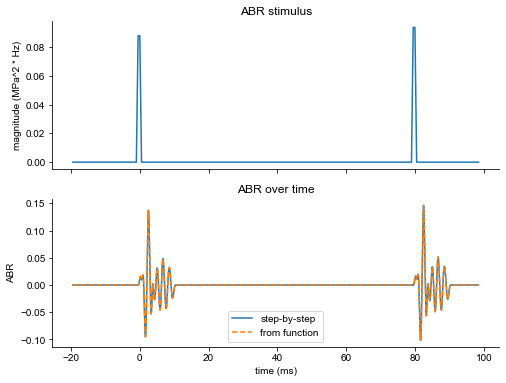

In [6]:
# Sum weighted dIdt over frequencies to get ABR input
logger.info('summing up over frequencies to get ABR input')
s_t = np.sum(weighted_dI_ft, axis=0)

# Resample s_t to match impulse_ABR sampling rate
dt_impulse = impulse_ABR.index.values[1] - impulse_ABR.index.values[0]  # ms
logger.info(f'resampling s_t at dt = {dt_impulse} ms')
tdense, s_t_dense = resample(times[:-1], s_t, dt_impulse * 1e-3)

# Convolve ABR input with ABR impulse response
logger.info('convolving ABR stim input with ABR impulse response to get ABR over time')
a_t = np.convolve(
    s_t_dense, impulse_ABR.values, mode='full')[:s_t_dense.size]

# Plot ABR stimulus and ABR response over time
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
for ax in axes:
    sns.despine(ax=ax)
axes[-1].set_xlabel('time (ms)')
ax = axes[0]
ax.set_title('ABR stimulus')
ax.set_ylabel('magnitude (MPa^2 * Hz)')
ax.plot(tdense * 1e3, s_t_dense)
ax = axes[1]
ax.set_title('ABR over time')
ax.set_ylabel('ABR')
ax.plot(tdense * 1e3, a_t, label='step-by-step')

# Make sure function outputs same evoked ABR
evoked_ABR = compute_predicted_ABR(
    ABR_thresholds, impulse_ABR, Fdrive, Pa_ref, tstim, tramp=ringup_time)
evoked_ABR.plot(ax=ax, ls='--', label='from function')

ax.legend();

### Compute ABR normalization factor

 2025/06/03 10:52:18: computing peak amplitude of evoked ABR for 80 ms rectangular pulse with P = 0.31 MPa
 2025/06/03 10:52:18: maximum evoked ABR = 0.18894331996148664 uV


<Axes: title={'center': 'Normalized ABR response'}, xlabel='time (ms)', ylabel='ABR (a.u.)'>

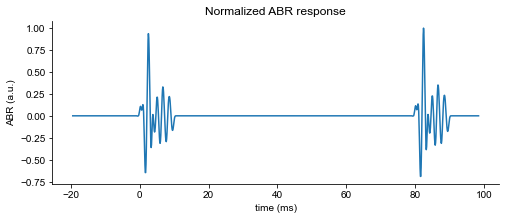

In [7]:
# Compute evoked ABR to 80 ms rectangular pulse with P = 0.31 MPa (PRMS = 0.22 MPa) 
Pa_max = 0.31  # MPa, i.e. 0.22 MPa RMS pressure
logger.info(f'computing peak amplitude of evoked ABR for 80 ms rectangular pulse with P = {Pa_max} MPa')
max_evoked_ABR = compute_predicted_ABR(
    ABR_thresholds, impulse_ABR, Fdrive, Pa_max, tstim, tramp=ringup_time)
R = max_evoked_ABR.abs().max()
logger.info(f'maximum evoked ABR = {R} uV')

# Normalize ABR response by maximum evoked ABR
norm_evoked_ABR = (max_evoked_ABR / R).rename('ABR (a.u.)')

# Plot normalized ABR response
fig, ax = plt.subplots(figsize=(8, 3))
sns.despine(ax=ax)
ax.set_title('Normalized ABR response')
ax.set_xlabel('time (ms)')
ax.set_ylabel('ABR (a.u.)')
norm_evoked_ABR.plot(ax=ax, label='normalized')

## Reproduce Hyun-Choi et al. (2023) trend

In [8]:
stimbounds_ms = (0, tstim * 1e3)  # stimulus bounds in ms

### Rectangular pulse: dependency on pressure amplitude (Fig 2A-C)

 2025/06/03 10:52:19: getting waveforms for different pressure amplitudes...
 2025/06/03 10:52:19: plotting waveforms for different pressure amplitudes...
 2025/06/03 10:52:20: computing evoked ABR for different pressure amplitudes...
 2025/06/03 10:52:20: plotting evoked ABR vs. pressure amplitude...


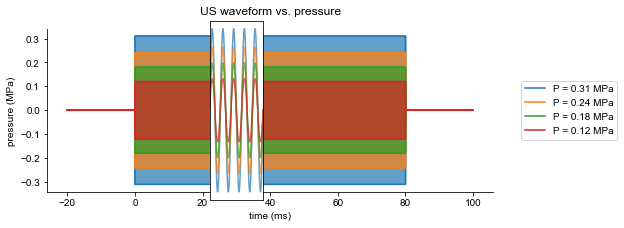

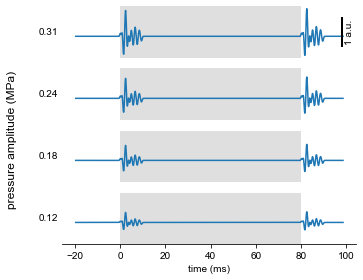

In [9]:
# Input vector
Pas = np.array([.12, .18, .24, .31])[::-1]  # MPa

# Get waveforms for each input
logger.info('getting waveforms for different pressure amplitudes...')
wfs_vs_Pa = {}
for Pa in Pas:
    wfs_vs_Pa[f'P = {Pa} MPa'] = get_waveform(Fdrive, Pa, tstim, tramp=ringup_time)

# Plot waveforms for each input
logger.info('plotting waveforms for different pressure amplitudes...')
fig, *_ = plot_waveform(
    wfs_vs_Pa, ylabel='pressure (MPa)', title='US waveform vs. pressure', 
    zoom_tbounds=zoom_tbounds)

# Compute evoked ABR for each input
logger.info('computing evoked ABR for different pressure amplitudes...')
evoked_ABR_vs_Pa = pd.concat({
    Pa: compute_predicted_ABR(ABR_thresholds, impulse_ABR, Fdrive, Pa, tstim, tramp=ringup_time, norm_factor=R) for Pa in Pas})
evoked_ABR_vs_Pa.index.set_names(['P (MPa)', evoked_ABR_vs_Pa.index.names[1]], inplace=True)

# Plot evoked ABR for each input
fig = plot_ABR_vs_parameter(
    evoked_ABR_vs_Pa, 'pressure amplitude', 'MPa', stim_tbounds=stimbounds_ms)

### Dependency on ramp duration (Fig 2D-I)

 2025/06/03 10:52:22: getting waveforms for different ramp durations...
 2025/06/03 10:52:23: plotting waveforms for different ramp durations...
 2025/06/03 10:52:24: computing evoked ABR for different ramp durations...
 2025/06/03 10:52:24: plotting evoked ABR vs. ramp time...


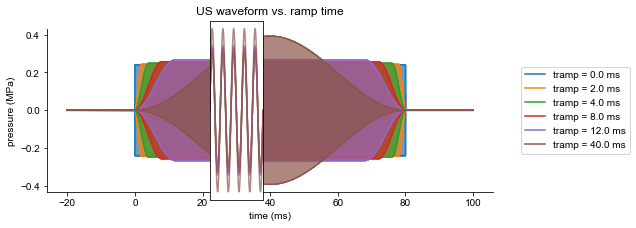

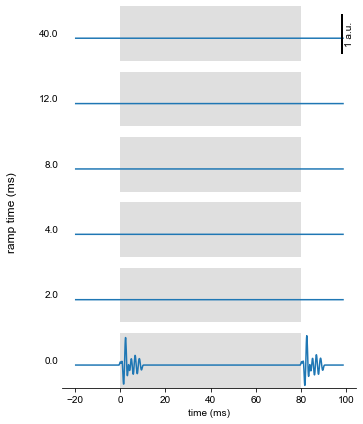

In [10]:
# Input vector
tramps_ms = np.array([ringup_time * 1e3, 2, 4, 8, 12, 40])  # ms

# Get waveforms for each input
logger.info('getting waveforms for different ramp durations...')
wfs_vs_tramp = {}
for tramp_ms in tramps_ms:
    wfs_vs_tramp[f'tramp = {tramp_ms} ms'] = get_waveform(
        Fdrive, Pa_ref, tstim, tramp=tramp_ms * 1e-3)

# Plot waveforms for each input
logger.info('plotting waveforms for different ramp durations...')
fig, *_ = plot_waveform(
    wfs_vs_tramp, ylabel='pressure (MPa)', title='US waveform vs. ramp time', 
    zoom_tbounds=zoom_tbounds)

# Compute evoked ABR for each input
logger.info('computing evoked ABR for different ramp durations...')
evoked_ABR_vs_tramp = pd.concat({
    tramp_ms: compute_predicted_ABR(
        ABR_thresholds, impulse_ABR, Fdrive, Pa_ref, tstim, tramp=tramp_ms * 1e-3, norm_factor=R)
    for tramp_ms in tramps_ms[::-1]
})
evoked_ABR_vs_tramp.index.set_names(['tramp (ms)', evoked_ABR_vs_tramp.index.names[1]], inplace=True)

# Plot evoked ABR for each input
fig = plot_ABR_vs_parameter(
    evoked_ABR_vs_tramp, 'ramp time', 'ms', stim_tbounds=stimbounds_ms)

### Rectangular: dependency on PRF (Figure 3 A-C) 

 2025/06/03 10:52:30: getting waveforms for different PRFs...
 2025/06/03 10:52:30: plotting waveforms for different PRFs...
 2025/06/03 10:52:32: computing evoked ABR for different PRFs...
 2025/06/03 10:52:32: plotting evoked ABR vs. PRF...


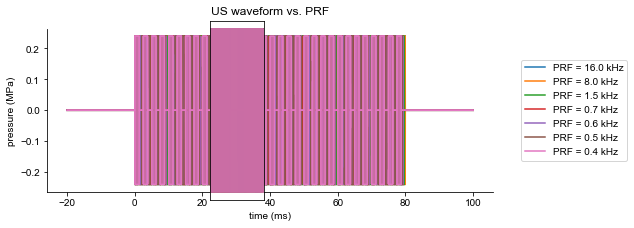

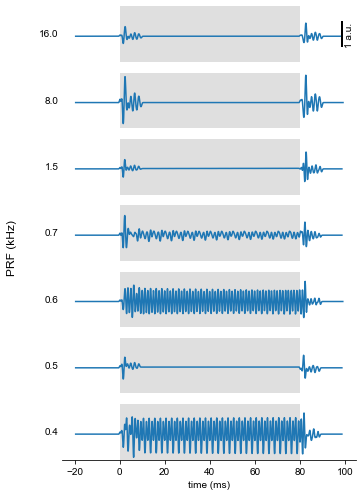

In [11]:
# Input vector
PRFs_kHz = np.array([.4, 0.5, .6, .7, 1.5, 8, 16])[::-1]  # kHz
# PRFs_kHz = np.round(np.logspace(np.log10(.5), np.log10(16), 20), 2)  # kHz
DC = 50.  # duty cycle (%)

# Get waveforms for each input
logger.info('getting waveforms for different PRFs...')
wfs_vs_PRF = {}
for PRF_kHz in PRFs_kHz:
    wfs_vs_PRF[f'PRF = {PRF_kHz} kHz'] = get_waveform(
        Fdrive, Pa_ref, tstim, tramp=ringup_time, PRF=PRF_kHz * 1e3, DC=DC)

# Plot waveforms for each input
logger.info('plotting waveforms for different PRFs...')
ext_zoom_tbounds = np.array([0, 2e-4]) + inset_tstart  # time bounds (s)
fig, *_ = plot_waveform(
    wfs_vs_PRF, ylabel='pressure (MPa)', title='US waveform vs. PRF', 
    zoom_tbounds=ext_zoom_tbounds)

# Compute evoked ABR for each input
logger.info('computing evoked ABR for different PRFs...')
evoked_ABR_vs_PRF = pd.concat({
    PRF_kHz: compute_predicted_ABR(
        ABR_thresholds, impulse_ABR, Fdrive, Pa_ref, tstim, 
        tramp=ringup_time, PRF=PRF_kHz * 1e3, DC=DC, norm_factor=R)
    for PRF_kHz in PRFs_kHz
})
evoked_ABR_vs_PRF.index.set_names(['PRF (kHz)', evoked_ABR_vs_PRF.index.names[1]], inplace=True)

# Plot evoked ABR for each input
fig = plot_ABR_vs_parameter(
    evoked_ABR_vs_PRF, 'PRF', 'kHz', stim_tbounds=stimbounds_ms)

## New predictions

### Rectangular: dependence on duty cycle

 2025/06/03 10:52:40: computing evoked ABR for DC = 0 - 100%


100%|██████████| 101/101 [00:11<00:00,  8.58it/s]

 2025/06/03 10:52:52: plotting evoked ABR vs. DC...


 2025/06/03 10:52:53: computing ABR energy for each DC


<Axes: xlabel='DC (%)', ylabel='ABR energy (uV^2)'>

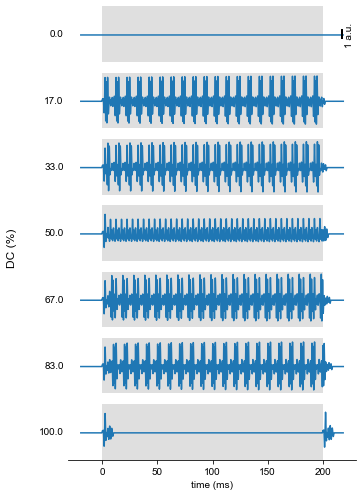

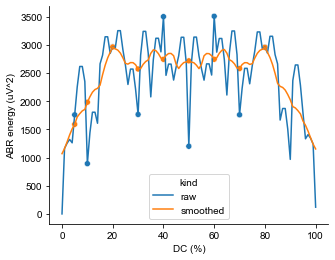

In [12]:
# Waveform parameters
# myFdrive = 2.1e6  # carrier frequency (Hz)
myPa = 0.8  # pressure amplitude (MPa)
mytstim = 200e-3  # burst duration (s)
myPRF = 100.  # burst internal PRF (Hz)
DCs = np.linspace(0, 100, 101)  # burst internal duty cycles (%)
mystimbounds_ms = (0, mytstim * 1e3)  # stimulus bounds in ms

# Compute evoked ABR signal for each DC
evoked_ABR_vs_DC = {}
logger.info(f'computing evoked ABR for DC = {DCs[0]:.0f} - {DCs[-1]:.0f}%')
for myDC in tqdm(DCs):
    evoked_ABR_vs_DC[myDC] = compute_predicted_ABR(
        ABR_thresholds, impulse_ABR, Fdrive, myPa, mytstim, PRF=myPRF, DC=myDC, norm_factor=R)
evoked_ABR_vs_DC = pd.concat(evoked_ABR_vs_DC)
evoked_ABR_vs_DC.index.set_names(['DC (%)', evoked_ABR_vs_DC.index.names[1]], inplace=True)

# Plot evoked ABR for characteristic DCs
nDCplot = 7
DCplot = np.linspace(DCs[0], DCs[-1], nDCplot)
DCplot = np.array([find_nearest(DCs, dc) for dc in DCplot])
fig = plot_ABR_vs_parameter(
    evoked_ABR_vs_DC.loc[pd.IndexSlice[DCplot, :]],
    'DC', '%', stim_tbounds=mystimbounds_ms)

# Compute and plot ABR energy for each DC
logger.info('computing ABR energy for each DC')
ABR_energy_vs_DC = (
    evoked_ABR_vs_DC
    .groupby('DC (%)')
    .agg(lambda x: (x**2).sum())
    .rename('ABR energy (uV^2)')
)

# Smooth ABR energy vs DC profile using a rolling window
ABR_energy_vs_DC_smoothed = pd.Series(
    apply_rolling_window(ABR_energy_vs_DC, w=11),
    index=ABR_energy_vs_DC.index,
    name=ABR_energy_vs_DC.name
)

# Assemble as multi-index Series
ABR_energy_vs_DC = pd.concat({
    'raw': ABR_energy_vs_DC,
    'smoothed': ABR_energy_vs_DC_smoothed
}, axis=0)

ABR_energy_vs_DC.index.names = ['kind', 'DC (%)']

# Plot ABR energy vs DC
fig, ax = plt.subplots(figsize=(5, 4))
sns.despine(ax=ax)
sns.lineplot(
    data=ABR_energy_vs_DC.reset_index(),
    ax=ax, 
    x='DC (%)',
    y='ABR energy (uV^2)', 
    hue='kind',
)

# Mark data points explored experimentally
DCexp = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80])  # %
sns.scatterplot(
    data=ABR_energy_vs_DC.loc[pd.IndexSlice[:, DCexp]].reset_index(),
    ax=ax, 
    x='DC (%)',
    y='ABR energy (uV^2)',
    hue='kind',
    legend=False
)

### Predictions with simplified activation function

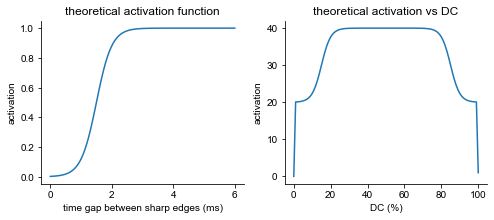

In [13]:
# Build theoretical activation function vs. gap between sharp edges
actfunc = lambda x: sigmoid(x, x0=1.5e-3, sigma=.25e-3) 

# Compute on and off times for each DC
mytons = (DCs * 1e-2) / myPRF
mytoffs = 1 / myPRF - mytons

# Compute theoretical activation per pulse 
actperpulse = actfunc(mytons) + actfunc(mytoffs)

# Scale by effective number of pulses at each DC
npulses_vs_DC = np.ones(DCs.size) * mytstim * myPRF
npulses_vs_DC[0] = 0
npulses_vs_DC[-1] = 1
act_vs_DC = actperpulse * npulses_vs_DC

# Plot theoretical predictions
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
sns.despine(fig=fig)
ax = axes[0]
ax.set_title('theoretical activation function')
ax.set_xlabel('time gap between sharp edges (ms)')
ax.set_ylabel('activation')
tgap = np.linspace(0, 6e-3, 101)  # s
ax.plot(tgap * S_TO_MS, actfunc(tgap))
ax = axes[1]
ax.set_xlabel('DC (%)')
ax.set_ylabel('activation')
ax.set_title('theoretical activation vs DC')
ax.plot(DCs, act_vs_DC)